In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Mounted at /content/gdrive


In [3]:
import torch
torch.__version__

'2.1.0+cu118'

In [4]:
# Imports

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# from going_modular.predictions import pred_and_plot_image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
%cd /content/gdrive/MyDrive/BE_Project/ViT_Implementation_Files/

/content/gdrive/MyDrive/BE_Project/ViT_Implementation_Files


In [7]:
# Set up paths of train and test data
train_dir = "data/train"
test_dir = "data/test"

In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [9]:
# get the number of CPUs available
NUM_WORKERS = os.cpu_count()
# Create DataLoader Function for loading the training and testing datasets
def create_dataloaders(
        train_dir: str,
        test_dir: str,
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int = NUM_WORKERS
):
    # Use ImageFolder() to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    # Get Class names
    class_names = train_data.classes
    # turn images into dataloaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return train_dataloader, test_dataloader, class_names

In [10]:
IMG_SIZE = 224
# Create transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [11]:
BATCH_SIZE = 32
# Create Dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir,
    test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
test_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ac28c14970>,
 ['A', 'B', 'C'])

Image shape: torch.Size([3, 224, 224]), label: 1


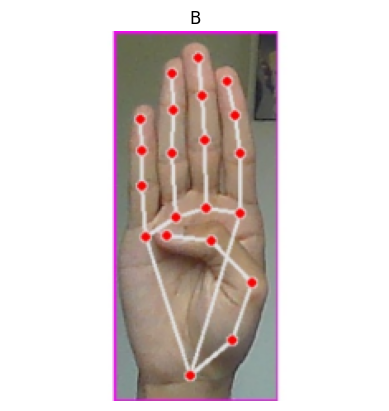

In [12]:
# Print a random image to verify
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(f"Image shape: {image.shape}, label: {label}")
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [13]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2-D input image into a 1-D sequence learnable embedding vector
    Args:
        in_channels (int): No of color channels for input image default=3 (RGB)
        patch_size (int): Size of a single patch default=16
        embedding_dim (int): Size of embedding to turn image into default=768
    """
    # 2. Initialize the class with appropriate variables
    def __init__(
            self,
            in_channels: int = 3,
            patch_size: int = 16,
            embedding_dim: int = 768
    ):
        super().__init__()
        # 3. Create a layer to turn image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        # 4. Create a layer to flatten the patch maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        # Only flatten the feature map dimensions into a single vector
    # 5. Define forward method
    def forward(self, x):
        # Create assertion to check that inputs are of correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, (f"input must be divisible by patch size, "
                                                    f"image shape: {image_resolution}, patch size: {patch_size}")
        # Perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure output shape has right order
        return x_flattened.permute(0, 2, 1)

In [14]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)



set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [15]:
# Create Multi headed attention block
class MultiHeadedSelfAttentionBlock(nn.Module):
    """
    Creates a Multi headed self attention block (MSA Block)
    """

    # Initialize class with hyperparameters from table 1
    def __init__(
            self,
            embedding_dim: int = 768,
            num_heads: int = 12,
            attn_dropout: float = 0
    ):
        super().__init__()

        # create the normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create MSA layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )

        # Create a forward method to pass data through the layers

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False
        )
        return attn_output

In [16]:
# Create MLP Block
class MLPBlock(nn.Module):
    """
    Creates a normalization layer with multilayer perceptron block (MLP block)
    """

    # initialize class parameters from table 1 & 3
    def __init__(
            self,
            embedding_dim: int = 768,
            mlp_size: int = 3072,
            dropout: float = 0.1
    ):
        super().__init__()

        # create the normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    # Create a forward method to pass data through layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [17]:
# Creating a transformer encoder block by combining all the layers
class TransformerEncoderBlock(nn.Module):
    """
    Creates a transformer encoder block
    """

    # initialize class parameters from table 1 & 3
    def __init__(
            self,
            embedding_dim: int = 768,
            num_heads: int = 12,
            mlp_size: int = 3072,
            mlp_dropout: float = 0.1,
            attn_dropout: float = 0
    ):
        super().__init__()

        # Create MSA Block
        self.msa_block = MultiHeadedSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )

        # Create MLP MLPBlock
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    # Create a forward method to pass data through layers
    def forward(self, x):
        # create residual connection for msa block (add input to the output)
        x = self.msa_block(x) + x

        # create residual connection for msa block (add input to the output)
        x = self.mlp_block(x) + x
        return x

In [18]:
!pip install torchinfo

In [19]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadedSelfAttentionBlock (msa_block)        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [20]:
# Building a Vision Transformer
class ViT(nn.Module):
    """
    Creates a ViT architecture with ViT-Base hyperparamters by default
    """
    # initialize class parameters from table 1 & 3
    def __init__(
            self,
            img_size: int = 224,
            in_channels: int = 3,
            patch_size: int = 16,
            num_transformer_layers: int = 12,
            embedding_dim: int = 768,
            mlp_size: int = 3072,
            num_heads: int = 12,
            attn_dropout: float = 0,
            mlp_dropout: float = 0.1,
            embedding_dropout: float = 0.1,
            num_classes: int = 1000
    ):
        super().__init__()
        # Make sure image size is divisioble by patch size
        assert img_size % patch_size == 0, (f"input must be divisible by patch size, "
                                            f"image shape: {img_size}, patch size: {patch_size}")
        # Calculate the number of patches = h*w/patch_size^2
        self.num_patches = (img_size * img_size) // patch_size ** 2
        # Create learnable class embedding (needs to go at front of sequence patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True
        )
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim),
            requires_grad=True
        )
        # create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )
        # Create transformer encoder blocks
        # We can stack them using nn.Sequential() NOTE: * means all
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout) for i in range(num_transformer_layers)])
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    # Create a forward method
    def forward(self, x):
        # get batch_size
        batch_size = x.shape[0]
        # Create class token embedding and expand it to match batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        # Create patch embedding
        x = self.patch_embedding(x)
        # Concat class embedding and patch embedding
        x = torch.cat((class_token, x), 1)
        # Add Position embedding to patch embedding
        x = self.position_embedding + x
        # Run embedding dropout
        x = self.embedding_dropout(x)
        # Pass patch, position and class embedding through encoder layers
        x = self.transformer_encoder(x)
        # Put 0 index logit through classifier
        x = self.classifier(x[:, 0])
        return x

In [21]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with
vit = ViT(num_classes=len(class_names))

In [22]:
from going_modular.going_modular import engine

In [28]:
# Set up the optimizer to optimize ViT model parameters using hyperparameters
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3,
    betas=(0.9, 0.999),
    weight_decay=0.3
)

# Set up the loss function for multi class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set Seeds so that on every machine the same random image is selected
torch.manual_seed(42)

# Train the model and save the results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1378 | train_acc: 0.3495 | test_loss: 1.2029 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.1281 | train_acc: 0.3503 | test_loss: 1.1162 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1172 | train_acc: 0.3610 | test_loss: 1.1264 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.1143 | train_acc: 0.3265 | test_loss: 1.1056 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.1047 | train_acc: 0.3421 | test_loss: 1.0972 | test_acc: 0.3750
Epoch: 6 | train_loss: 1.1023 | train_acc: 0.3257 | test_loss: 1.1013 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.1032 | train_acc: 0.3248 | test_loss: 1.1007 | test_acc: 0.3125
Epoch: 8 | train_loss: 1.0994 | train_acc: 0.3331 | test_loss: 1.0990 | test_acc: 0.3125
Epoch: 9 | train_loss: 1.0991 | train_acc: 0.3199 | test_loss: 1.0987 | test_acc: 0.3125
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3331 | test_loss: 1.0990 | test_acc: 0.3125


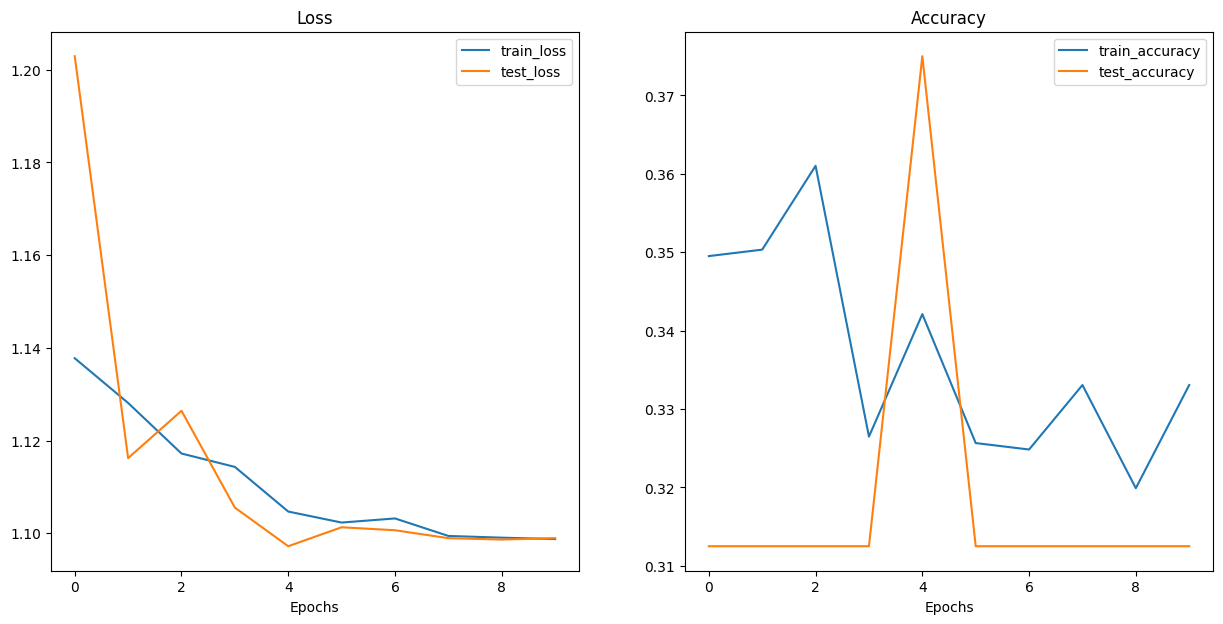

In [42]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

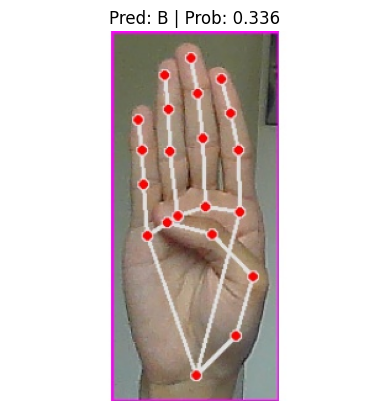

In [47]:
import requests
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image
# Make Predictions
image_path = "data/test/B/B_401.jpg"
pred_and_plot_image(
    model=vit,
    image_path=image_path,
    class_names=class_names
)